In [1]:
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm
import re
from os import listdir

%matplotlib inline
mpl.rcParams['pdf.fonttype'] = 42

In [51]:
# Load line profile Analysis Results
grps = ['DMSO','Taxol','5ITu']
df_res_list = []

for grp in grps:
    df_res = pd.read_json('AnalysisResults/LineProfileAnalysisResult_%s.json' %grp)
    df_res_list.append(df_res)


In [56]:
# import FLIM data mat files
from scipy import io
mat = io.loadmat('dist_all_result_bin8_WT.mat')
FLIMWT = {'edges':mat['Edge'][0][0].flatten(),'mean_FRET_fraction':mat['mean_Y_dist'][0][0].flatten(),
          'std_FRET_fraction':mat['std_Y_dist'][0][0].flatten(),'X':mat['X'][0][0].flatten()}

mat = io.loadmat('dist_all_result_bin8_Treated.mat')
FLIM5ITu = {'edges':mat['Edge'][0][0].flatten(),'mean_FRET_fraction':mat['mean_Y_dist'][0][0].flatten(),
          'std_FRET_fraction':mat['std_Y_dist'][0][0].flatten(),'X':mat['X'][0][0].flatten()}

mat = io.loadmat('dist_all_result_bin4_Taxol.mat')
FLIMTaxol = {'edges':mat['Edge'][0][0].flatten(),'mean_FRET_fraction':mat['mean_Y_dist'][0][0].flatten(),
          'std_FRET_fraction':mat['std_Y_dist'][0][0].flatten(),'X':mat['X'][0][0].flatten()}


In [57]:
def findFWHM(prof,dx=0.1):
    x = np.arange(len(prof))
    f = sp.interpolate.interp1d(x,prof,kind='cubic')
    xnew,dx = np.linspace(0,np.max(x),np.int(np.max(x)/dx)+1,retstep=True)
    intp_prof = f(xnew)
    m = np.max(intp_prof)
    zero_crossings = np.where(np.diff(np.sign(intp_prof-m/2)))[0]
    return (zero_crossings[1]-zero_crossings[0])*dx

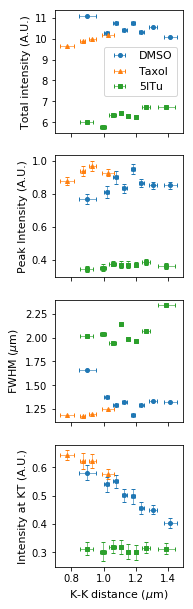

In [58]:
pixsize = 8190/60/1.5/1.2/512 #um

#plot the chracteristics of INCENP profiles

fig,ax = plt.subplots(nrows=4,ncols=1,figsize=(2.7,8.6),sharex=True)
fmts = ['o','^','s']
fs = 11
ms=4
ew = 0.6
for j,df_res in enumerate(df_res_list):
    ax[0].errorbar(df_res['avgkkdist']*pixsize,df_res['avgprof560'].apply(np.sum),
                   xerr=df_res['sdkkdist']*pixsize,fmt=fmts[j],capsize=2,mec=None,ms=ms,elinewidth=ew)
    ax[1].errorbar(df_res['avgkkdist']*pixsize,df_res['avgprof560'].apply(np.max),xerr=df_res['sdkkdist']*pixsize,
                   yerr=df_res.apply(lambda row:row['semprof560'][np.argmax(row['avgprof560'])],axis=1),
                   fmt=fmts[j],capsize=2,mec=None,ms=ms,elinewidth=ew)
    ax[2].errorbar(df_res['avgkkdist']*pixsize,df_res['avgprof560'].apply(findFWHM)*pixsize,
                   xerr=df_res['sdkkdist']*pixsize,fmt=fmts[j],capsize=2,mec=None,ms=ms,elinewidth=ew)
    ax[3].errorbar(df_res['avgkkdist']*pixsize,df_res['avgintatkin'],
                   xerr=df_res['sdkkdist']*pixsize,yerr=df_res['semintatkin'],
                   fmt=fmts[j],capsize=2,mec=None,ms=ms,elinewidth=ew)
    
ax[0].set_ylabel('Total intensity (A.U.)',fontsize=fs)
ax[1].set_ylabel('Peak Intensity (A.U.)',fontsize=fs)
ax[0].legend(['DMSO','Taxol','5ITu'],fontsize=fs)
#ax[0].legend(['DMSO','Taxol'],fontsize=fs)
ax[2].set_ylabel('FWHM ($\mu$m)',fontsize=fs)
ax[3].set_ylabel('Intensity at KT (A.U.)',fontsize=fs)
ax[3].set_xlabel('K-K distance ($\mu$m)',fontsize=fs)

plt.tight_layout()

#fig.savefig('AnalysisSummary_cytobgNorm.pdf',facecolor=None,edgecolor=None)
#fig.savefig('AnalysisSummary.pdf',facecolor=None,edgecolor=None)

In [ ]:
# Plot only intensity at KT, because that's meaningful. Add linear model
fig = plt.figure(figsize=(3,3))

fmts = ['o','^','s']
fs = 11
ms=4
ew = 0.6
for j,df_res in enumerate(df_res_list):
    ax[0].errorbar(df_res['avgkkdist']*pixsize,df_res['avgprof560'].apply(np.sum),
                   xerr=df_res['sdkkdist']*pixsize,fmt=fmts[j],capsize=2,mec=None,ms=ms,elinewidth=ew)
    ax[1].errorbar(df_res['avgkkdist']*pixsize,df_res['avgprof560'].apply(np.max),xerr=df_res['sdkkdist']*pixsize,
                   yerr=df_res.apply(lambda row:row['semprof560'][np.argmax(row['avgprof560'])],axis=1),
                   fmt=fmts[j],capsize=2,mec=None,ms=ms,elinewidth=ew)
    ax[2].errorbar(df_res['avgkkdist']*pixsize,df_res['avgprof560'].apply(findFWHM)*pixsize,
                   xerr=df_res['sdkkdist']*pixsize,fmt=fmts[j],capsize=2,mec=None,ms=ms,elinewidth=ew)
    ax[3].errorbar(df_res['avgkkdist']*pixsize,df_res['avgintatkin'],
                   xerr=df_res['sdkkdist']*pixsize,yerr=df_res['semintatkin'],
                   fmt=fmts[j],capsize=2,mec=None,ms=ms,elinewidth=ew)
    
ax[0].set_ylabel('Total intensity (A.U.)',fontsize=fs)
ax[1].set_ylabel('Peak Intensity (A.U.)',fontsize=fs)
ax[0].legend(['DMSO','Taxol','5ITu'],fontsize=fs)
#ax[0].legend(['DMSO','Taxol'],fontsize=fs)
ax[2].set_ylabel('FWHM ($\mu$m)',fontsize=fs)
ax[3].set_ylabel('Intensity at KT (A.U.)',fontsize=fs)
ax[3].set_xlabel('K-K distance ($\mu$m)',fontsize=fs)

plt.tight_layout()


In [61]:
# # plot NDC80 Binding fraction vs Aurora B level (in real concentration), average 5ITu data

# fs=12
# FLIM_list = [FLIMWT,FLIMTaxol,FLIM5ITu]
# fmts = ['o','^','s']
# ms=4
# ew=0.6
# convfactor = 0.42   #FRET fraction  -> binding conversion factor
# AuroraPeakConc = 10     #Aurora B peak concentration (from Zaytsev et al Elife)

# fig = plt.figure(figsize=(3,3))
# for i in range(3):
#     if (i != 2):
#         plt.errorbar(df_res_list[i]['avgintatkin']*AuroraPeakConc,FLIM_list[i]['mean_FRET_fraction']/convfactor,
#                      xerr=df_res_list[i]['semintatkin']*AuroraPeakConc,yerr=FLIM_list[i]['std_FRET_fraction']/convfactor,
#                      fmt=fmts[i],capsize=2,mec=None,ms=ms,elinewidth=ew)
#     elif (i == 2):
#         X = df_res_list[i]['avgintatkin'].values*AuroraPeakConc
#         dX = df_res_list[i]['semintatkin'].values*AuroraPeakConc
#         Y = FLIM_list[i]['mean_FRET_fraction']/convfactor
#         dY = FLIM_list[i]['std_FRET_fraction']/convfactor

#         meanX = (X/dX**2).sum()/(1/dX**2).sum()  #weighted average
#         semX = np.sqrt(1/(1/dX**2).sum())
#         meanY = (Y/dY**2).sum()/(1/dY**2).sum()  #weighted average
#         semY = np.sqrt(1/(1/dY**2).sum())
        
#         plt.errorbar(meanX,meanY,xerr=semX,yerr=semY,fmt=fmts[i],capsize=2,mec=None,ms=ms,elinewidth=ew)

# plt.xlabel('Aurora B concentration ($\mu$M)',fontsize=fs)
# plt.ylabel('NDC80 binding fraction',fontsize=fs)
# plt.legend(['None','Taxol','5ITu'])
# plt.tight_layout()

# #fig.savefig('AuroraB_vs_NDC80bindingfraction.pdf',edgecolor=None,facecolor=None)

[ 8.  2.  2.  1.  2.  2.  2.  1.]


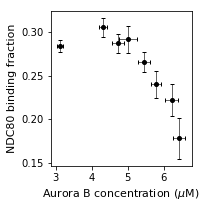

In [62]:
# plot NDC80 Binding fraction vs Aurora B level (in real concentration), bin average

ms=4
ew=0.6
convfactor = 0.42   #FRET fraction  -> binding conversion factor
AuroraPeakConc = 10     #Aurora B peak concentration (from Zaytsev et al Elife)
fs = 11

# bin average the NDC80 binding fraction vs Aurora B level plot
X = np.concatenate([df_res['avgintatkin'].values for df_res in df_res_list])
dX = np.concatenate([df_res['semintatkin'].values for df_res in df_res_list])
Y = np.concatenate([df['mean_FRET_fraction']/convfactor for df in FLIM_list])
dY = np.concatenate([df['std_FRET_fraction']/convfactor for df in FLIM_list])

edges = [0.25,0.4,0.455,0.5,0.525,0.55,0.6,0.625,0.65]
meanX = np.zeros(len(edges)-1)
semX = np.zeros(len(edges)-1)
meanY = np.zeros(len(edges)-1)
semY = np.zeros(len(edges)-1)
N = np.zeros(len(edges)-1)
for i in range(len(edges)-1):
    sel = (X<edges[i+1]) & (X>=edges[i])
    meanX[i] = (X[sel]/dX[sel]**2).sum()/(1/dX[sel]**2).sum()  #weighted average
    semX[i] = np.sqrt(1/(1/dX[sel]**2).sum())
    meanY[i] = (Y[sel]/dY[sel]**2).sum()/(1/dY[sel]**2).sum()  #weighted average
    semY[i] = np.sqrt(1/(1/dY[sel]**2).sum())
    N[i] = (sel).sum()

print(N)
fig = plt.figure(figsize=(3,3))
plt.errorbar(meanX*AuroraPeakConc,meanY,
             xerr=semX*AuroraPeakConc,yerr=semY,fmt='o',color='k',capsize=2,mec=None,ms=ms,elinewidth=ew)

plt.xlabel('Aurora B concentration ($\mu$M)',fontsize=fs)
plt.ylabel('NDC80 binding fraction',fontsize=fs)
plt.tight_layout()

#fig.savefig('AuroraB_vs_NDC80bindingfraction_binned.pdf',edgecolor=None,facecolor=None)

In [63]:
#NDC80 binding vs Aurora B concentration model:
def activeAur_vs_Aur_model(x,alpha,C):
    #active Aurora B level
    Aa = np.zeros(len(x))
    Aa[x<(alpha+C)] = C-alpha
    Aa[x>=(alpha+C)] = x[x>=(alpha+C)]-2*alpha
    
    return Aa

def NDC80_phosphor_vs_Aur_model(x,alpha,beta,C):
    Aa = activeAur_vs_Aur_model(x,alpha,C)
    
    return Aa/(Aa+beta)
    
def binding_vs_Aur_model(p,x):
    #constants 
    a1 = 0.21
    b1 = 3.26
    c1 = 0.21
    a2 = 0.17
    b2 = 1.95
    c2 = 0.37
    C = 3.12 #uM
    
    alpha,beta = p
    
    P = NDC80_phosphor_vs_Aur_model(x,alpha,beta,C)
    y = a1*(1-(9*P)**(b2/b1))+c1
    
    return y
    

[2.0123601616102569, 20.093002584423662] [ 0.2856059   5.76944732]


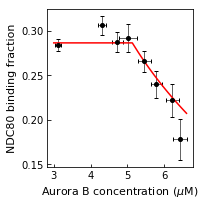

In [64]:
from kapteyn import kmpfit

#Fitting NDC80 binding vs Aurora concentration data
fit = kmpfit.simplefit(binding_vs_Aur_model,[2,10],meanX*AuroraPeakConc,meanY,err=semY)

print(fit.params, np.sqrt(np.diag(fit.covar)))

fig = plt.figure(figsize=(3,3))
plt.errorbar(meanX*AuroraPeakConc,meanY,
             xerr=semX*AuroraPeakConc,yerr=semY,fmt='o',color='k',capsize=2,mec=None,ms=ms,elinewidth=ew)

# plot fit
xx = np.linspace(3,6.6,num=50)
yy = binding_vs_Aur_model(fit.params,xx)
plt.plot(xx,yy,'r-')

plt.xlabel('Aurora B concentration ($\mu$M)',fontsize=fs)
plt.ylabel('NDC80 binding fraction',fontsize=fs)

ax = plt.gca()
ax.tick_params(direction='in')

plt.tight_layout()

#fig.savefig('AuroraB_vs_NDC80bindingfraction_binned_w_fit.pdf',edgecolor=None,facecolor=None)

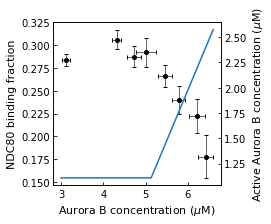

In [71]:
#Active Aurora B concentration vs Aurora concentration

alpha,beta = fit.params
C = 3.12

fig, ax1 = plt.subplots(figsize=(3,3))
ax2 = ax1.twinx()

activeAur = activeAur_vs_Aur_model(xx,alpha,C)

ax1.errorbar(meanX*AuroraPeakConc,meanY,
             xerr=semX*AuroraPeakConc,yerr=semY,fmt='o',color='k',capsize=2,mec=None,ms=ms,elinewidth=ew)
ax2.plot(xx,activeAur)

ax1.set_xlabel('Aurora B concentration ($\mu$M)',fontsize=fs)
ax1.set_ylabel('NDC80 binding fraction',fontsize=fs)
ax2.set_ylabel('Active Aurora B concentration ($\mu$M)',fontsize=fs)
ax1.tick_params(direction='in')
ax2.tick_params(direction='in')

In [ ]:
fig,ax = plt.subplots(nrows=3,ncols=1,figsize=(7,3))



# Active Aurora B concentration
ax[0]

